In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
import h5py
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import umap

/home/sj225/miniconda3/envs/scbert/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def hopkins(X, m=None):
    """Calculate the Hopkins statistic for the given dataset."""
    n, d = X.shape

    if m is None:
        m = int(0.1 * n)  # Use 10% of the data as the sample size
    if m < 1:
        raise ValueError("Sample size m must be at least 1")

    # Fit NearestNeighbors on the dataset
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)

    # Generate m random samples uniformly distributed within the range of X
    random_samples = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))

    # Randomly sample m points from the dataset
    real_samples = X[np.random.choice(n, m, replace=False)]

    # Calculate nearest neighbor distances for random samples
    u_distances, _ = nbrs.kneighbors(random_samples, n_neighbors=1)
    # Calculate nearest neighbor distances for real samples
    w_distances, _ = nbrs.kneighbors(real_samples, n_neighbors=2)  # Exclude the point itself

    # Sum of distances
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances[:, 1])  # Exclude the point itself

    # Compute the Hopkins statistic
    H = u_sum / (u_sum + w_sum)
    return H

def hopkins_statistic(X):
    n, d = X.shape
    m = int(0.1 * n)  # Use 10% of the data as the sample size
    nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(X)
    
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    
    u_dist, _ = nbrs.kneighbors(rand_X, n_neighbors=2)
    u_dist = u_dist[:, 1]  # Distance to the nearest neighbor in the actual data
    w_dist, _ = nbrs.kneighbors(X[np.random.choice(n, m, replace=False)], n_neighbors=2)
    w_dist = w_dist[:, 1]  # Distance to the nearest neighbor in the sample
    
    H = sum(u_dist) / (sum(u_dist) + sum(w_dist))
    return H

def plot_umap(embedding_file, selected_samples, output_file='umap_plot.png'):
    # 读取嵌入数据
    embedding_df = pd.read_csv(embedding_file, header=None)
    
    # 创建UMAP对象并拟合数据
    reducer = umap.UMAP()
    embedding_2d = reducer.fit_transform(embedding_df.values)
    
    # 创建颜色数组，所有样本为灰色，选定样本为红色
    colors = ['grey'] * len(embedding_df)
    for idx in selected_samples:
        colors[idx] = 'red'
    
    # 绘制UMAP图
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, s=1)
    plt.title('UMAP projection of the embeddings')
    plt.savefig(output_file)
    plt.show()

Selected samples from genes: 423
Selected samples from adt: 423
Iteration 1, Control samples: 423


/tmp/ipykernel_2189382/3844403691.py:50: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  selected_embedding = embedding_df.loc[selected_samples]
/tmp/ipykernel_2189382/3844403691.py:51: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  selected_cluster = cluster_df.loc[selected_samples]


Iteration 2, Control samples: 423
Iteration 3, Control samples: 423
Iteration 4, Control samples: 423
Iteration 5, Control samples: 423
Iteration 6, Control samples: 423
Iteration 7, Control samples: 423
Iteration 8, Control samples: 423
Iteration 9, Control samples: 423
Iteration 10, Control samples: 423
Iteration 11, Control samples: 423
Iteration 12, Control samples: 423
Iteration 13, Control samples: 423
Iteration 14, Control samples: 423
Iteration 15, Control samples: 423
Iteration 16, Control samples: 423
Iteration 17, Control samples: 423
Iteration 18, Control samples: 423
Iteration 19, Control samples: 423
Iteration 20, Control samples: 423
Iteration 21, Control samples: 423
Iteration 22, Control samples: 423
Iteration 23, Control samples: 423
Iteration 24, Control samples: 423
Iteration 25, Control samples: 423
Iteration 26, Control samples: 423
Iteration 27, Control samples: 423
Iteration 28, Control samples: 423
Iteration 29, Control samples: 423
Iteration 30, Control sample

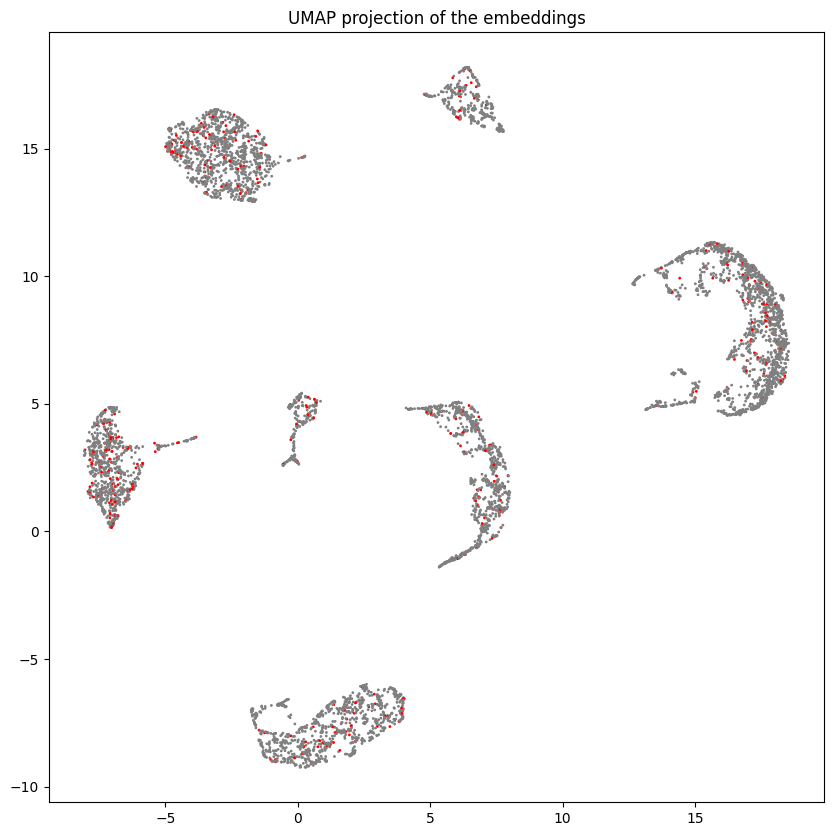

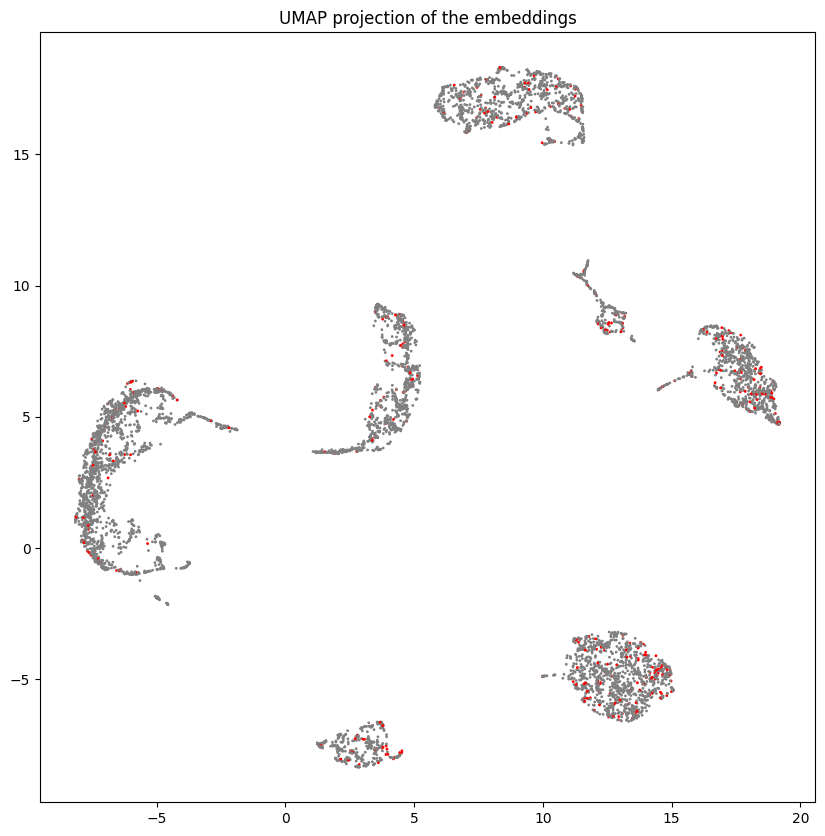

In [16]:

def process_data(data_file, dataset_name, filter_file, adt_input, mark_gene, embedding_file, cluster_file, output_file, n_iterations=100):
    # 读取HDF5文件
    data_mat = h5py.File(data_file, 'r')

    # 提取数据集
    data = np.array(data_mat[dataset_name])
    data_df = pd.DataFrame(data)
    
    # 提取ADT
    adt = np.array(data_mat['X2'])
    adt_df = pd.DataFrame(adt)

    # 如果是X1，设置列名为基因列表
    if (dataset_name == 'X1'):
        genes_dataset = data_mat['Genes']
        genes_list = [gene.decode('utf-8') for gene in genes_dataset[:]]
        data_df.columns = genes_list
        
    
    adt_dataset = data_mat['ADT']
    adt_list = [adt.decode('utf-8') for adt in adt_dataset[:]]
    adt_df.columns = adt_list

    # #读取过滤文件并去掉对应行
    filter_indices = pd.read_csv(filter_file, header=None).squeeze().tolist()
    data_df.drop(filter_indices, axis=0, inplace=True)
    # #重置索引
    data_df.reset_index(drop=True, inplace=True)

    # 分别从data_df和adt_df筛选出Mark_Gene表达不为0的样本
    selected_samples = set(data_df[data_df[mark_gene] != 0].index.tolist())
    print(f"Selected samples from genes: {len(selected_samples)}")
    
    selected_samples_adt = set(adt_df.nlargest(len(selected_samples), adt_input).index.tolist())
    print(f"Selected samples from adt: {len(selected_samples_adt)}")

    # 输出筛选后的样本列表
    with open(output_file, 'w') as f:
        for sample in selected_samples:
            f.write(f"{sample}\n")

    # 从所有样本中随机选择N次control样本并计算统计量
    all_samples = data_df.index.tolist()
    hopkins_values_control = []
    silhouette_scores_control = []
    # 读取嵌入和聚类数据
    embedding_df = pd.read_csv(embedding_file, header=None)
    cluster_df = pd.read_csv(cluster_file, header=None)
    
    selected_embedding = embedding_df.loc[selected_samples]
    selected_cluster = cluster_df.loc[selected_samples]
    
    for i in range(n_iterations):
        control_samples = np.random.choice(all_samples, len(selected_samples), replace=False).tolist()
        print(f"Iteration {i+1}, Control samples: {len(control_samples)}")
        # 选出需要的样本行
        
        control_embedding = embedding_df.loc[control_samples]
        control_cluster = cluster_df.loc[control_samples]

        # 计算霍普金斯统计量
        hopkins_value_selected = hopkins_statistic(selected_embedding.values)
        hopkins_value_control = hopkins_statistic(control_embedding.values)
        # print(f"Hopkins statistic for selected samples: {hopkins_value_selected}")
        # print(f"Hopkins statistic for control samples: {hopkins_value_control}")

        # 计算Silhouette Score
        sil_score_selected = silhouette_score(selected_embedding, selected_cluster.squeeze())
        sil_score_control = silhouette_score(control_embedding, control_cluster.squeeze())
        # print(f"Silhouette Score for selected samples: {sil_score_selected}")
        # print(f"Silhouette Score for control samples: {sil_score_control}")

        hopkins_values_control.append(hopkins_value_control)
        silhouette_scores_control.append(sil_score_control)
        
    # 使用Wilcoxon签名秩检验计算p值
    p_value_hopkins = wilcoxon([hopkins_value_selected] * n_iterations, hopkins_values_control, alternative='greater').pvalue
    p_value_silhouette = wilcoxon([sil_score_selected] * n_iterations, silhouette_scores_control, alternative='greater').pvalue

    print(f"p-value for Hopkins statistic: {p_value_hopkins}")
    print(f"p-value for Silhouette Score: {p_value_silhouette}")
    
    # print the average score for selected samples
    print(f"Average Hopkins statistic for selected samples: {hopkins_value_selected}") 
    print(f"Average Silhouette Score for selected samples: {sil_score_selected}")
    
    # print the average score for control samples
    print(f"Average Hopkins statistic for control samples: {np.mean(hopkins_values_control)}")
    print(f"Average Silhouette Score for control samples: {np.mean(silhouette_scores_control)}")
    


    # 判断显著性
    alpha = 0.05
    if p_value_hopkins < alpha:
        print("Hopkins statistic for selected samples is significantly greater than control samples.")
    else:
        print("No significant difference in Hopkins statistic between selected and control samples.")

    if p_value_silhouette < alpha:
        print("Silhouette Score for selected samples is significantly greater than control samples.")
    else:
        print("No significant difference in Silhouette Score between selected and control samples.")

    # 调用plot_umap函数
    plot_umap(embedding_file, selected_samples, output_file='umap_plot.png')
    plot_umap(embedding_file, selected_samples_adt, output_file='umap_plot_adt.png')
    

# 调用
process_data(
    data_file='/project/zhiwei/sj225/MultiSC/Input/GSE178707_neatseq_lane1.h5',
    dataset_name='X1',
    filter_file='/project/zhiwei/sj225/MultiSC/result3/line1//FOXP3/1_cellfilter.csv',
    mark_gene='IL2RA',
    adt_input='FOXP3',   ##可以不用管，画图用的
    embedding_file='/project/zhiwei/sj225/MultiSC/result3/line1/FOXP3/1_embedding.csv',
    cluster_file='/project/zhiwei/sj225/MultiSC/result3/line1/FOXP3/1_pred.csv',
    output_file='filtered_cells.txt',
    n_iterations=100  # 设置控制样本随机选择的次数
)